In [1]:
from keras.models import Sequential, Model

from keras.layers import Dense, Embedding, Reshape, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint
from IPython.display import SVG

from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

Using TensorFlow backend.


In [18]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from matplotlib import pyplot as plt
from matplotlib import style

In [19]:
style.use('fivethirtyeight')

In [3]:
batch_size = 32
img_height = 256
img_width = 256

img_folder = '/home/jupyter/DeCoreIdea/decore_style'

In [5]:
# attempts at data augmentation
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/home/jupyter/DeCoreIdea/decore_style',  # this is the target directory
        target_size=(256, 256),  # all images will be resized to 150x150
        batch_size=batch_size)  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/home/jupyter/DeCoreIdea/decore_style',
        target_size=(256, 256),
        batch_size=batch_size)

Found 2467 images belonging to 10 classes.
Found 2467 images belonging to 10 classes.


In [4]:
#obtaining the training dataset
train_ds = image_dataset_from_directory(
  img_folder,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2415 files belonging to 8 classes.
Using 1932 files for training.


2021-09-03 03:46:26.310359: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200245000 Hz
2021-09-03 03:46:26.312746: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5605b184da90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-03 03:46:26.312783: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-09-03 03:46:26.313058: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
#obtaining the validation dataset
val_ds = image_dataset_from_directory(
  img_folder,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2415 files belonging to 8 classes.
Using 483 files for validation.


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [7]:
y_train = np.concatenate([y for x, y in train_ds], axis=0)
x_train = np.concatenate([x for x, y in train_ds], axis=0)

y_val = np.concatenate([y for x, y in val_ds], axis=0)
x_val = np.concatenate([x for x, y in val_ds], axis=0)


In [8]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(x_train.reshape(1932, 196608), y_train.reshape(1932,))
lr.score(x_val.reshape(483, 196608), y_val.reshape(483,))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.11801242236024845

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
preds = lr.predict(x_val.reshape(483, 196608))

In [85]:
lr_cm = multilabel_confusion_matrix(y_val.reshape(483,1), preds.reshape(483,1))

In [91]:
lr_cm

array([[[363,  57],
        [ 53,  10]],

       [[363,  57],
        [ 54,   9]],

       [[363,  61],
        [ 55,   4]],

       [[374,  55],
        [ 48,   6]],

       [[367,  53],
        [ 55,   8]],

       [[368,  48],
        [ 62,   5]],

       [[380,  45],
        [ 53,   5]],

       [[377,  50],
        [ 46,  10]]])

Text(0.5, 1.0, 'Logistic Regression Baseline')

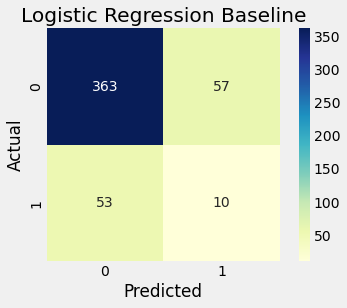

In [92]:
from sklearn.metrics import multilabel_confusion_matrix

#looks like the logistic regression model is only guessing the first 4 classes and mainly class 0 which is bohemian
sns.heatmap(lr_cm[0], cmap=plt.cm.YlGnBu, annot=True,fmt ='d', square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Baseline')


In [9]:
from keras.applications.mobilenet import MobileNet

In [10]:
mobile_base = MobileNet(weights='imagenet', 
                          include_top=False,
                          input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

In [11]:
flat2 = Flatten()(mobile_base.layers[-1].output)
class2 = Dense(1024, activation='relu', kernel_regularizer='l2')(flat2)
dropout1 = Dropout(0.3)(class2)
class3 = Dense(512, activation='relu', kernel_regularizer='l2')(dropout1)
dropout2 = Dropout(0.3)(class3)
output2 = Dense(8, activation='softmax')(dropout2)
# define new model
model2 = Model(inputs=mobile_base.inputs, outputs=output2)
# summarize
model2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32)     

In [12]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
history = model2.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)  # track progress as we fit

Epoch 1/5
61/61 [==============================] - 199s 3s/step - loss: 34.9785 - accuracy: 0.1988 - val_loss: 64.1610 - val_accuracy: 0.1304
Epoch 2/5
61/61 [==============================] - 195s 3s/step - loss: 15.6269 - accuracy: 0.3421 - val_loss: 11.9310 - val_accuracy: 0.2919
Epoch 3/5
61/61 [==============================] - 190s 3s/step - loss: 8.9666 - accuracy: 0.4306 - val_loss: 9.2515 - val_accuracy: 0.2422
Epoch 4/5
61/61 [==============================] - 198s 3s/step - loss: 5.9713 - accuracy: 0.5052 - val_loss: 6.3445 - val_accuracy: 0.2795
Epoch 5/5
61/61 [==============================] - 194s 3s/step - loss: 4.3798 - accuracy: 0.5921 - val_loss: 6.0559 - val_accuracy: 0.1636


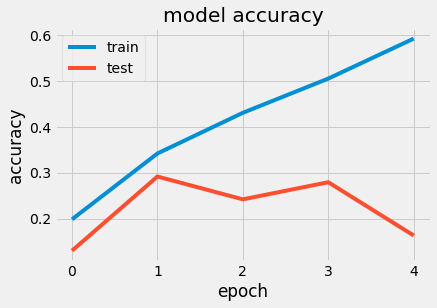

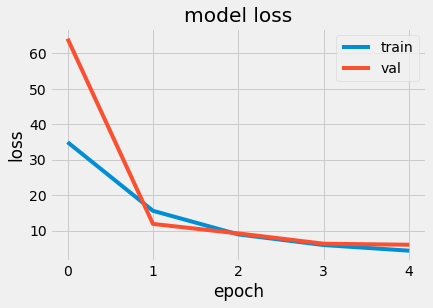

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.figure(figsize=(20, 20))
plt.savefig('mobilenet_accuracy.png', bbox_inches='tight')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.figure(figsize=(20, 20))
plt.savefig('mobilenet_loss.png', bbox_inches='tight')
plt.show()


In [51]:
preds2 = model2.predict(x_val)


In [55]:
pred_conv = np.argmax(preds2, axis=1)

In [103]:
mobilenet_cm = multilabel_confusion_matrix(y_val.reshape(483,1), pred_conv)
mobilenet_cm

array([[[420,   0],
        [ 63,   0]],

       [[403,  17],
        [ 62,   1]],

       [[417,   7],
        [ 57,   2]],

       [[ 58, 371],
        [  4,  50]],

       [[398,  22],
        [ 60,   3]],

       [[412,   4],
        [ 66,   1]],

       [[423,   2],
        [ 58,   0]],

       [[424,   3],
        [ 56,   0]]])

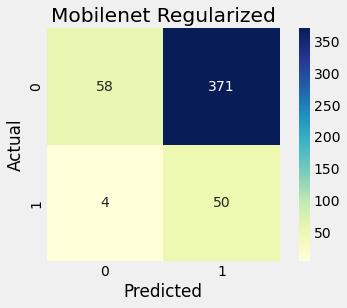

In [102]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(mobilenet_cm[3], cmap=plt.cm.YlGnBu, annot=True,fmt ='d', square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Mobilenet Regularized')
plt.savefig('mobilenet_cm.png');

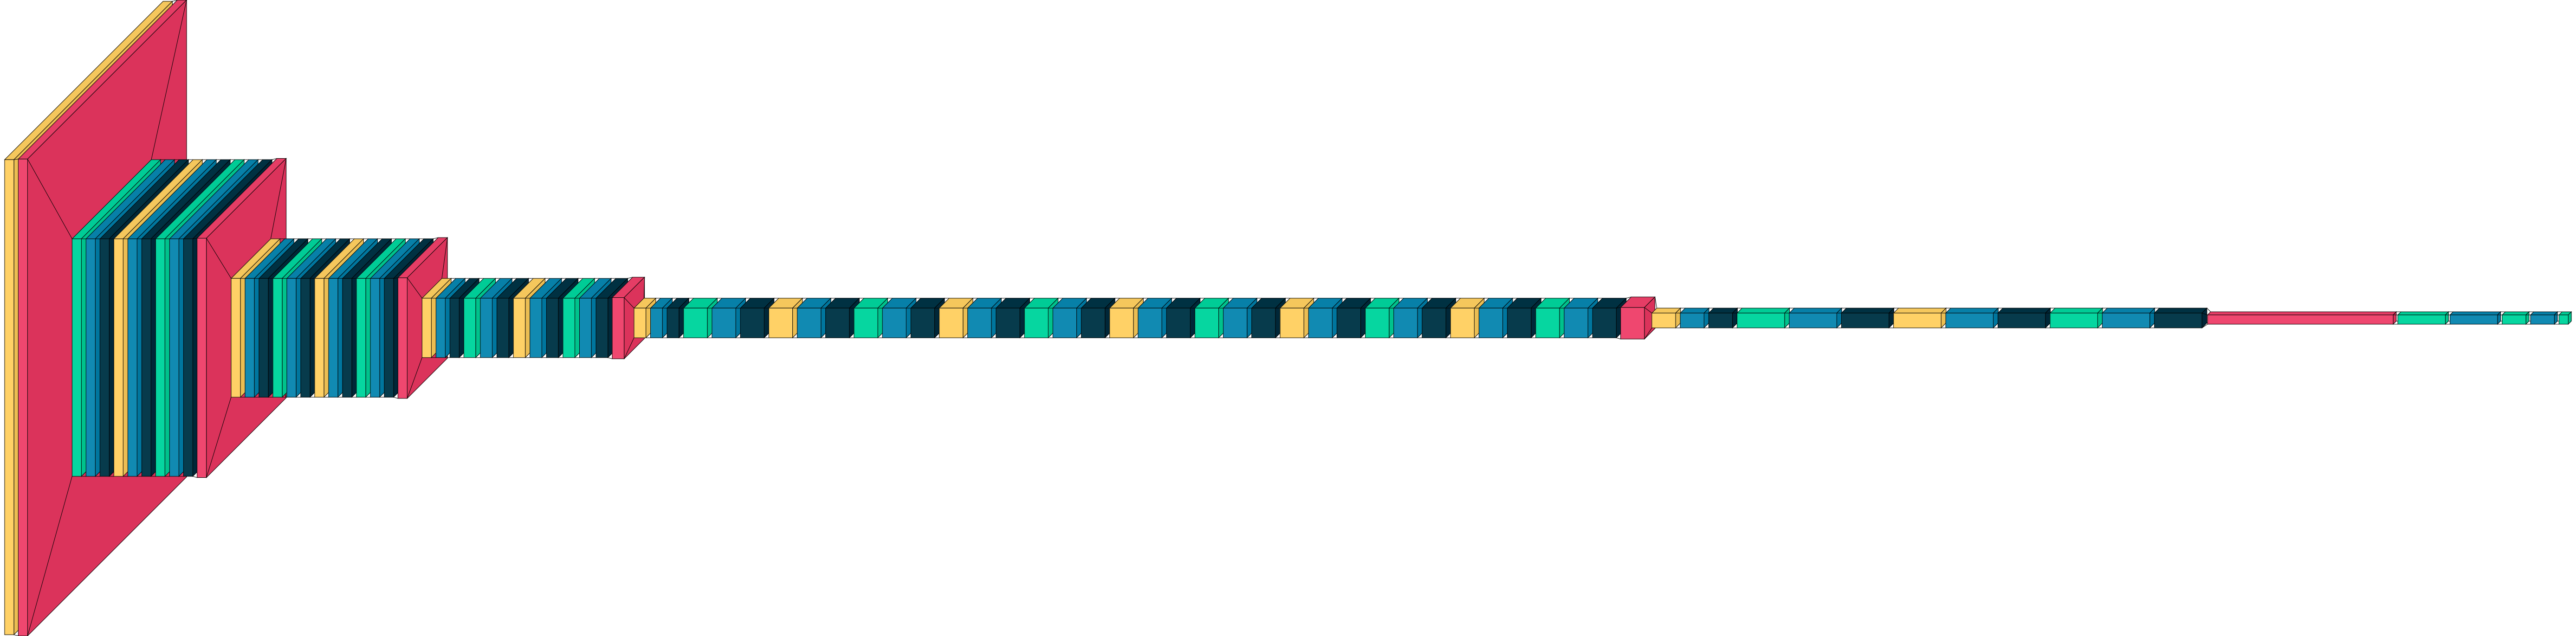

In [27]:
import visualkeras

visualkeras.layered_view(model2, to_file='output.png').show() # write and show


In [44]:
# Instantiate convolutional base from imagenet data
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

In [45]:
flat1 = Flatten()(conv_base.layers[-1].output)
class1 = Dense(1024, activation='relu', kernel_regularizer='l2')(flat1)
dropout0 = Dropout(0.3)(class1)
class0 = Dense(512, activation='relu', kernel_regularizer='l2')(dropout0)
dropout1 = Dropout(0.3)(class0)
output1 = Dense(8, activation='softmax')(dropout1)
# define new model
model1 = Model(inputs=conv_base.inputs, outputs=output1)
# summarize
model1.summary()

Model: "functional_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)     

In [46]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
model1.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)  # track progress as we fit

Epoch 1/5
61/61 [==============================] - 629s 10s/step - loss: 29.4564 - accuracy: 0.1180 - val_loss: 19.1709 - val_accuracy: 0.1222
Epoch 2/5
61/61 [==============================] - 627s 10s/step - loss: 16.9526 - accuracy: 0.1165 - val_loss: 14.8550 - val_accuracy: 0.1201
Epoch 3/5
61/61 [==============================] - 623s 10s/step - loss: 13.5848 - accuracy: 0.1377 - val_loss: 12.2817 - val_accuracy: 0.1180
Epoch 4/5
61/61 [==============================] - 619s 10s/step - loss: 11.3490 - accuracy: 0.1366 - val_loss: 10.4575 - val_accuracy: 0.1159
Epoch 5/5
61/61 [==============================] - 615s 10s/step - loss: 9.7593 - accuracy: 0.1247 - val_loss: 9.0913 - val_accuracy: 0.1118


In [48]:
from tensorflow.keras.applications import ResNet50

In [49]:
resnet50_base = ResNet50(weights='imagenet', 
                          include_top=False,
                          input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

In [52]:
flat3 = Flatten()(resnet50_base.layers[-1].output)
class4 = Dense(1024, activation='relu', kernel_regularizer='l2')(flat3)
dropout3 = Dropout(0.3)(class4)
class5 = Dense(512, activation='relu', kernel_regularizer='l2')(dropout3)
dropout4 = Dropout(0.3)(class5)
output3 = Dense(8, activation='softmax')(dropout4)
# define new model
model3 = Model(inputs=resnet50_base.inputs, outputs=output3)
# summarize
model3.summary()

Model: "functional_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [53]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
model3.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)  # track progress as we fit

Epoch 1/5
61/61 [==============================] - 469s 8s/step - loss: 38.3720 - accuracy: 0.1605 - val_loss: 134209.8281 - val_accuracy: 0.1159
Epoch 2/5
61/61 [==============================] - 456s 7s/step - loss: 16.1185 - accuracy: 0.1848 - val_loss: 63.8638 - val_accuracy: 0.1491
Epoch 3/5
61/61 [==============================] - 461s 8s/step - loss: 8.6135 - accuracy: 0.2371 - val_loss: 14.1987 - val_accuracy: 0.1739
Epoch 4/5
61/61 [==============================] - 464s 8s/step - loss: 5.9556 - accuracy: 0.2562 - val_loss: 8.9606 - val_accuracy: 0.1925
Epoch 5/5
61/61 [==============================] - 463s 8s/step - loss: 4.7797 - accuracy: 0.3163 - val_loss: 4.7759 - val_accuracy: 0.2091
